# importations
***

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import keras.layers
import keras.metrics
import keras.optimizers
from IPython.display import clear_output
import keras.callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , confusion_matrix , roc_auc_score , precision_recall_curve

# loading data and splitting it
***
we gotta split the train test now so if we planned to change train set it wont affect distribution of test set and etc

In [53]:
ds = pd.read_csv(r'D:\datasets\diabetes\diabetes.csv')

In [54]:
train , test = train_test_split(ds , test_size = 0.1 , shuffle = True , random_state = 42)
train , val = train_test_split(train , test_size = 0.1 , shuffle = True , random_state = 42)

and this shows we dont have any null values in our dataset and its good

In [55]:
ds.isnull().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

In [56]:
train.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000
mean,3.768116,121.043478,68.723027,20.339775,80.181965,32.009018,0.470504,32.458937,0.341385
std,3.356892,32.342418,19.514195,15.702132,116.021303,7.930536,0.339454,11.069152,0.474557
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.200000,0.241000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,37.000000,32.000000,0.370000,29.000000,0.000000
75%,6.000000,140.000000,80.000000,32.000000,130.000000,36.600000,0.612000,39.000000,1.000000
max,17.000000,199.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


and our data isnt that imbalanced too and its good

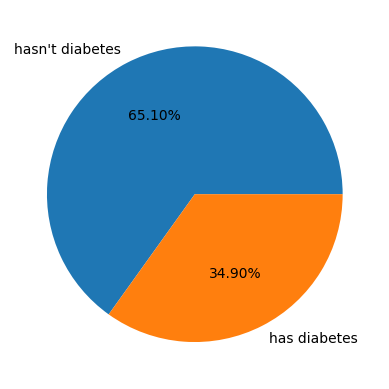

In [57]:
plt.pie(ds['Outcome'].value_counts() , autopct = '%1.2f%%' , labels = ['hasn\'t diabetes' , 'has diabetes'])
plt.show()

but the correlations doesnt look good so we have to not rely on regression that much

<Axes: >

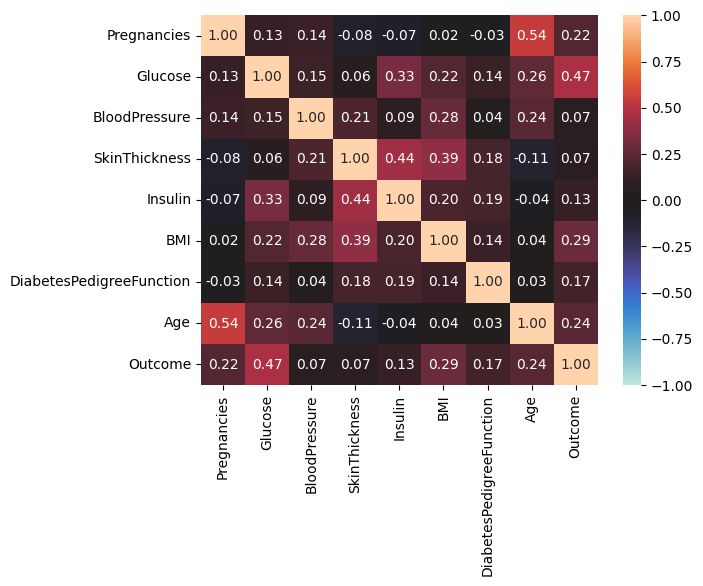

In [58]:
sns.heatmap(ds.corr() , annot = True , fmt = '0.2f' , vmin = -1 , center = 0)

but if we did we gotta drop `Glucose` and `BloodPressure` and `BMI` and `Age` for our regression model

In [59]:
exo_train = train.drop('Outcome' , axis = 1)
exo_col = exo_train.columns
col_count = len(exo_col)
VIFs = [VIF(exog = exo_train , exog_idx = i) for i in range(col_count)]
exo_VIFs = pd.DataFrame(data = VIFs , index = exo_col , columns = ['VIF'])
exo_VIFs

,VIF
Pregnancies,3.394036
Glucose,17.022834
BloodPressure,14.313769
SkinThickness,4.105644
Insulin,2.111566
BMI,17.612157
DiabetesPedigreeFunction,3.102552
Age,14.775989


In [60]:
X = train.drop(axis = 1 , labels = 'Outcome')
y = train['Outcome']

x_val = val.drop(axis = 1 , labels = 'Outcome')
y_val = val['Outcome']

x_test = test.drop(axis = 1 , labels = 'Outcome')
y_test = test['Outcome']

In [61]:
normalizer = MinMaxScaler()

X = normalizer.fit_transform(X)

x_val = normalizer.fit_transform(x_val)

x_test = normalizer.fit_transform(x_test)

# training and testing
***

In [62]:
model = keras.Sequential([
    keras.layers.Dense(300 , input_shape = (8 ,)),
    keras.layers.Dense(600 , activation = 'elu'),
    keras.layers.Dense(200 , activation = 'elu'),
    keras.layers.Dense(200 , activation = 'elu'),
    keras.layers.Dense(200 , activation = 'elu'),
    keras.layers.Dense(1 , activation = 'sigmoid')
])

model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.000005) , loss = 'binary_crossentropy' , metrics = [keras.metrics.binary_accuracy])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 300)               2700      
                                                                 
 dense_25 (Dense)            (None, 600)               180600    
                                                                 
 dense_26 (Dense)            (None, 200)               120200    
                                                                 
 dense_27 (Dense)            (None, 200)               40200     
                                                                 
 dense_28 (Dense)            (None, 200)               40200     
                                                                 
 dense_29 (Dense)            (None, 1)                 201       
                                                                 
Total params: 384,101
Trainable params: 384,101
Non-tr

In [63]:
earlystop = keras.callbacks.EarlyStopping(monitor = 'val_binary_accuracy' , patience = 400 , restore_best_weights = True)

i chose a smaller `batch_size` because of having a kinda small dataset

In [64]:
history = model.fit(x = X , y = y , validation_data = (x_val , y_val) , epochs = 1000 , batch_size = 22 , callbacks = [earlystop])

Epoch 1/1000
29/29 [==============================] - 1s 9ms/step - loss: 0.6816 - binary_accuracy: 0.6361 - val_loss: 0.6834 - val_binary_accuracy: 0.5714
Epoch 2/1000
29/29 [==============================] - 0s 5ms/step - loss: 0.6668 - binary_accuracy: 0.6570 - val_loss: 0.6852 - val_binary_accuracy: 0.5857
Epoch 3/1000
29/29 [==============================] - 0s 5ms/step - loss: 0.6596 - binary_accuracy: 0.6586 - val_loss: 0.6864 - val_binary_accuracy: 0.5857
Epoch 4/1000
29/29 [==============================] - 0s 5ms/step - loss: 0.6559 - binary_accuracy: 0.6586 - val_loss: 0.6883 - val_binary_accuracy: 0.5857
Epoch 5/1000
29/29 [==============================] - 0s 5ms/step - loss: 0.6528 - binary_accuracy: 0.6586 - val_loss: 0.6865 - val_binary_accuracy: 0.5857
Epoch 6/1000
29/29 [==============================] - 0s 5ms/step - loss: 0.6504 - binary_accuracy: 0.6602 - val_loss: 0.6867 - val_binary_accuracy: 0.5857
Epoch 7/1000
29/29 [==============================] - 0s 5ms/ste

In [ ]:
# model.save('model.h5')

<Axes: >

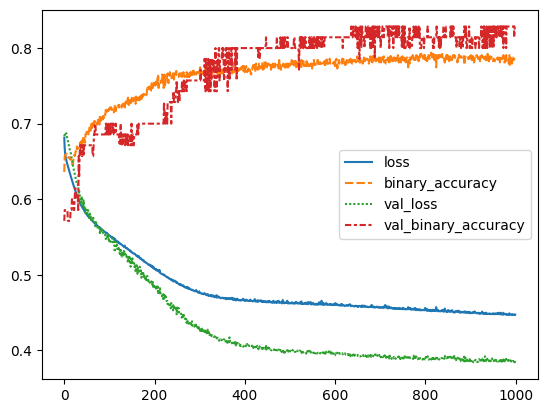

In [66]:
sns.lineplot(history.history)

we have probablities as our predictions. so we gotta find the best threshold. we calculate f1 for every thresholds and find which threshold gives us best f1 score and we apply it and we will have binary values instead of continueous probablities.

In [67]:
predictions = model.predict(x_test)
precisions , recalls , thresholds = precision_recall_curve(y_true = y_test , probas_pred = predictions)

f1s = (2 * precisions * recalls) / (precisions + recalls)
best_f1_ind = np.nanargmax(f1s)

THE_threshold = thresholds[best_f1_ind]
THE_f1 = f1s[best_f1_ind]

final_preds = np.where(predictions > THE_threshold , 1 , 0)
clear_output()

and testing our model with test set with these metrics

In [68]:
acc_score = accuracy_score(y_test , final_preds)
conf_mat = confusion_matrix(y_test , final_preds)

roc_auc = roc_auc_score(y_test , final_preds)
avg_acc = (((conf_mat[0][0] / (conf_mat[0][0] + conf_mat[0][1])) + (conf_mat[1][1] / (conf_mat[1][1] + conf_mat[1][0]))) / 2)

# results
***

<Axes: >

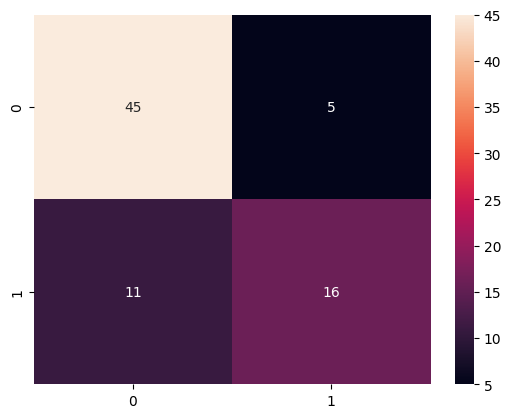

In [69]:
sns.heatmap(conf_mat , annot = True)

In [70]:
pd.DataFrame(data = [acc_score , avg_acc , roc_auc , THE_f1] , index = ['accuracy' , 'average accuracy' , 'roc auc' , 'f1'] , columns = ['results'])

,results
accuracy,0.792208
average accuracy,0.746296
roc auc,0.746296
f1,0.693878


### not a bad model after all